In [140]:
import mercury as mr
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from IPython.display import Markdown, display
import numpy as np

In [2]:
%matplotlib inline

In [149]:
def printmd(string, color = None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [163]:
def colorize(string, color = None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    return colorstr

In [8]:
# Make an easy way for ambiguous nucleotides to be easily identified
def format_nucleotides(nucleotide_string):
    formatted_string = ""
    for char in nucleotide_string:
        if char in "ATCG":
            formatted_string += char
        else:
            formatted_string += "<span style='background: gray; color:red; font-weight:bold, font-size: 250%'>{}</span>".format(char)
    printmd(formatted_string)

In [232]:
show_code = mr.Checkbox(value=False, label="Show code")

mercury.Checkbox

In [233]:
app = mr.App(title="16s Sequencing Data Analysis", description = "Use to trim Sanger sequencing, merge fwd and reverse reads", \
             show_code = show_code.value)

mercury.App

## Forward read plots

In [234]:
file1 = mr.File(label = 'Upload forward read', max_file_size = '10MB')

mercury.File

In [235]:
print(f"Uploaded file name: {file1.filename}")
print(f"Uploaded file path: {file1.filepath}")

Uploaded file name: Sample2-655978001_27fwd16srRNA.ab1
Uploaded file path: /tmp/tmpw0t58xux/Sample2-655978001_27fwd16srRNA.ab1


In [236]:
def generate_trimmed_fasta_with_ambiguities(output_title, base_calls, ambiguous_dict, \
                                            trim_start, trim_end, orient = 'F'):
    """
    Generates a FASTA file with only the trimmed sequence and ambiguous base calls.

    Args:
        output_title (str): Title for the FASTA file.
        base_calls (str): Original base calls as a string.
        ambiguous_dict (dict): Dictionary mapping positions (0-based) to IUPAC codes.
        trim_start (int): Start position for trimming (0-based).
        trim_end (int): End position for trimming (0-based).
    
    Returns:
        None. Outputs a trimmed FASTA file.
    """
    # Convert the base_calls string into a list for easy modification
    sequence_with_ambiguities = list(base_calls)

    # Replace bases at ambiguous positions with the corresponding IUPAC code
    for pos, iupac_code in ambiguous_dict.items():
        if trim_start <= pos < trim_end:  # Only modify positions within the trimmed range
            sequence_with_ambiguities[pos] = iupac_code

    # Slice the sequence to include only the trimmed portion
    trimmed_sequence_with_ambiguities = ''.join(sequence_with_ambiguities[trim_start:trim_end])
    sequence = Seq(trimmed_sequence_with_ambiguities)

    # Create a SeqRecord object for writing to FASTA
    seq_record = SeqRecord(sequence, id=output_title, description="Trimmed sequence with ambiguous base calls")

    # Write the trimmed sequence to a FASTA file
    # fasta_file = f"{output_title}_trimmed.fasta"
    
    # with open(fasta_file, "w") as output_handle:
    
        #if orient == 'R':
            #SeqIO.write(seq_record.reverse_complement(), output_handle, "fasta")
        
        #else:
            #SeqIO.write(seq_record, output_handle, "fasta")

    # print(f"Trimmed FASTA file '{fasta_file}' has been generated.")
    
    return seq_record

In [237]:
# Translate ambiguous calls to IUPAC code
def translate_to_iupac(ambiguous_bases):
    # Sort the ambiguous bases to ensure they match the dictionary keys
    sorted_bases = ''.join(sorted(ambiguous_bases))
    return base_to_iupac.get(sorted_bases, 'N')  # Return 'N' if no match is found

# Parameters
quality_threshold = 40     # Quality score threshold for trimming
min_consecutive_bases = 5  # Minimum number of consecutive high-quality bases needed to determine trim point

# Function to find the first and last position to keep based on quality threshold
def find_trim_position(phred_scores, direction='start'):
    if direction == 'start':
        for i in range(len(phred_scores) - min_consecutive_bases + 1):
            if all(score >= quality_threshold for score in phred_scores[i:i + min_consecutive_bases]):
                return i
    elif direction == 'end':
        for i in range(len(phred_scores) - min_consecutive_bases, -1, -1):
            if all(score >= quality_threshold for score in phred_scores[i:i + min_consecutive_bases]):
                return i + min_consecutive_bases
    return None

In [256]:
# IUPAC nucleotide code dictionary
iupac_codes = {
    "A": "A",
    "C": "C",
    "G": "G",
    "T": "T",
    "R": "AG",    # A or G
    "Y": "CT",    # C or T
    "S": "GC",    # G or C
    "W": "AT",    # A or T
    "K": "GT",    # G or T
    "M": "AC",    # A or C
    "B": "CGT",   # C or G or T
    "D": "AGT",   # A or G or T
    "H": "ACT",   # A or C or T
    "V": "ACG",   # A or C or G
    "N": "ACGT"   # any base
}

# Reverse mapping from bases to IUPAC code
base_to_iupac = {''.join(sorted(v)): k for k, v in iupac_codes.items()}

In [239]:
#seq1_title = mr.Text(value='sequence', label='Name this sequence', rows = 1)

In [258]:
def make_ambig_calls_and_plot(record, orient = 'F', output_title = 'sequence'):

    # Extract peak locations, base calls, and quality scores
    peak_locations = record.annotations['abif_raw']['PLOC2']
    base_calls = record.annotations['abif_raw']['PBAS2'].decode('ascii')
    phred_scores = record.letter_annotations["phred_quality"]

    # Find high-quality trimming positions
    trim_start = find_trim_position(phred_scores, 'start')
    trim_end = find_trim_position(phred_scores, 'end')
    trimmed_len = trim_end - trim_start

    # Define ambiguity threshold and the number of bases per plot
    ambiguity_threshold = 3  # e.g., highest peak must be 3 times greater than the next highest
    bases_per_plot = 50

    # Extract trace data for G, A, T, C
    channels = ['DATA9', 'DATA10', 'DATA11', 'DATA12']
    trace_data = {base: record.annotations['abif_raw'][channel] for base, channel in zip("GATC", channels)}

    # Find global max intensity and max Phred score for consistent plotting
    max_intensity = max(max(trace_data[base]) for base in "GATC")
    max_phred_score = max(phred_scores)

    # Set consistent y-limits
    intensity_ylim = (-0.4, max_intensity * 1.1)  # a little above max to give space
    phred_ylim = (0, max_phred_score + 5)  # add a small buffer above max Phred

    # Initialize lists for ambiguous positions, original base calls, and alternatives
    ambiguous_positions = []
    original_base_calls = []
    alternative_base_calls = []
    alternative_intensities = []

    # Loop through all positions in the sequence to check for ambiguity
    for i, position in enumerate(peak_locations):
        intensities = {base: trace_data[base][position] for base in "GATC"}
        sorted_bases = sorted(intensities, key=intensities.get, reverse=True)

        # Check for ambiguous base calls based on the threshold
        if intensities[sorted_bases[0]] < ambiguity_threshold * intensities[sorted_bases[1]]:
            ambiguous_positions.append(i)
            original_base_calls.append(base_calls[i])
            alternatives = [(base, intensities[base]) for base in sorted_bases if intensities[base] >= intensities[sorted_bases[0]] / ambiguity_threshold]
            alternative_base_calls.append([base for base, _ in alternatives])
            alternative_intensities.append([intensity for _, intensity in alternatives])

    # Make a dictionary with the position of the ambiguous calls and the corresponding IUPAC code
    ambiguous_dict = {}
    for position, alternatives in zip(ambiguous_positions, alternative_base_calls):
        ambiguous_dict[position] = translate_to_iupac(alternatives)

    # Loop through the sequence in chunks of `bases_per_plot` and plot each chunk
    # num_chunks = len(base_calls) // bases_per_plot + (1 if len(base_calls) % bases_per_plot else 0)

    # Output the start and end positions for trimming (adjusted for display purposes)
    print("Trim Start Position:", trim_start + 1)  # Adjust display only (shifted by 1)
    print("Trim End Position:", trim_end)  # No need to adjust since this is end-exclusive

    # Set initial values for start and end based on the number of bases per plot
    # Set initial values for start and end based on the number of bases per plot
    start = 0
    end = min(len(base_calls), bases_per_plot)  # Show first 50 bases initially
    
    # Plot the trace data for the initial chunk
    fig, ax1 = plt.subplots(figsize=(15, 3))
    plt.subplots_adjust(bottom=0.25)
    colors = {'A': 'green', 'C': 'blue', 'G': 'black', 'T': 'red'}
    slider_color = 'White'
    
    # Create a secondary y-axis for Phred scores
    ax2 = ax1.twinx()

    # App slider widget
    pos_to_plot = mr.Slider(value=0, min=0, max=len(base_calls), label="Region to view", 
                        step=1, url_key="slider")
    
    # Function to plot the current chunk of data
    def plot_chunk(start, end):
        ax1.clear()  # Clear previous data
        ax2.clear()  # Clear Phred score data

        for i, position in enumerate(peak_locations[start:end]):
            for base in "GACT":
                ax1.plot(start + i + 1, trace_data[base][position], 'o', color=colors[base], label=base if start + i == 0 else "")
        
        # Annotate original base calls below the x-axis
        for i, (pos, base_call) in enumerate(zip(range(start + 1, end + 1), base_calls[start:end])):
            ax1.text(pos, -0.15, base_call, ha='center', va='top', transform=ax1.get_xaxis_transform(), fontsize=10)
    
        # Annotate ambiguous calls
        for pos in range(start, end):
            if pos in ambiguous_dict:
                ax1.text(pos + 1, -0.25, ambiguous_dict[pos], ha='center', va='top', transform=ax1.get_xaxis_transform(), fontsize=9, \
                         color='black', backgroundcolor = 'orange', fontweight = 'bold')
    
        # Set plot limits and labels
        ax1.set_xlim(start + 1, end)
        ax1.set_ylim(intensity_ylim)
        #ax1.set_xlabel('Base Number')
        ax1.set_ylabel('Signal Intensity')
        ax1.set_title(f'Sanger Sequencing Chromatogram (Bases {start + 1} to {end})')
    
        # Update the Phred score axis
        ax2.plot(range(start + 1, end + 1), phred_scores[start:end], 's-', color='purple', label='Phred Quality Score', alpha=0.7)
        ax2.set_ylabel('Phred Quality Score')
        ax2.yaxis.set_label_position("right")
        ax2.yaxis.tick_right()
        ax2.set_ylim(phred_ylim)
        ax2.legend(loc="upper right")
        ax1.legend(loc="upper left")
        plt.draw()

    # Initial plot of the first chunk
    plot_chunk(pos_to_plot.value, pos_to_plot.value + 75)
    
    # Slider params
    #axis_position = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=slider_color)
    #slider_position = Slider(axis_position, 'Pos', 0, max(0, len(base_calls) - bases_per_plot))
    
    # Update function for the slider
    #def update(val):
        #pos = int(slider_position.val)
        #start = pos
        #end = min(start + bases_per_plot, len(base_calls))
        #plot_chunk(start, end)
    
    # Connect the slider to the update function
    #slider_position.on_changed(update)
    
    # Display the plot
    plt.show()


    # Convert the base_calls string into a list for easy modification
    sequence_with_ambiguities = list(base_calls)

    # Replace bases at ambiguous positions with the corresponding IUPAC code
    for pos, iupac_code in ambiguous_dict.items():
        sequence_with_ambiguities[pos] = iupac_code

    # Slice the sequence to include only the trimmed portion
    trimmed_sequence_with_ambiguities = ''.join(sequence_with_ambiguities[trim_start:trim_end])
    sequence = Seq(trimmed_sequence_with_ambiguities)

    # Create a SeqRecord object for writing to FASTA
    seq_record = SeqRecord(sequence, id=output_title, description="Trimmed sequence with ambiguous base calls")

    # Write the trimmed sequence to a FASTA file
    # fasta_file = f"{output_title}_trimmed.fasta"
    
    # with open(fasta_file, "w") as output_handle:
    
        #if orient == 'R':
            #SeqIO.write(seq_record.reverse_complement(), output_handle, "fasta")
        
        #else:
            #SeqIO.write(seq_record, output_handle, "fasta")

    # print(f"Trimmed FASTA file '{fasta_file}' has been generated.")

    # Assuming `base_calls` is the original base calls string, `ambiguous_dict` contains ambiguous positions,
    # and `trim_start` and `trim_end` are the start and end positions for trimming.
    
    # seq_record = generate_trimmed_fasta_with_ambiguities(output_title, base_calls, ambiguous_dict, trim_start, trim_end, orient=orient)
    # Include the Phred scores with the seq record
    seq_record.letter_annotations["phred_score"] = phred_scores[trim_start:trim_end]

    # Handle reverse complement if needed
    if orient == 'R':
        phred_scores.reverse()
        return seq_record.reverse_complement()
    else:
        return seq_record

In [241]:
#generate1 = mr.Button(label = "Generate fwd plots")

In [242]:
#if generate1.clicked:
    

Trim Start Position: 42
Trim End Position: 808


mercury.Slider

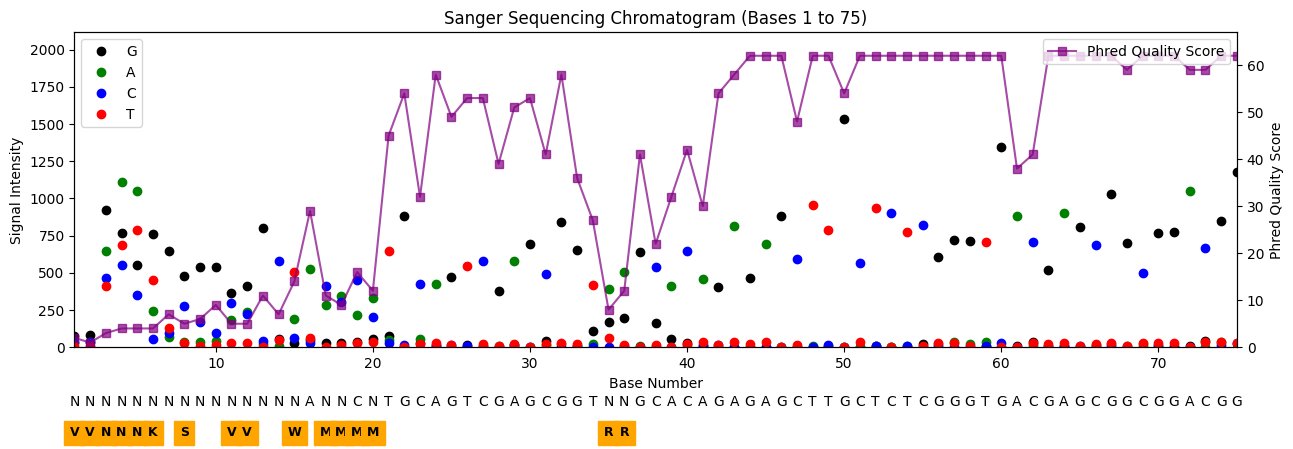

In [243]:
record1 = None
if file1.filepath is not None:
    with open(file1.filepath, "rb") as infile:
        record1 = SeqIO.read(infile, "abi")
    seq1 = make_ambig_calls_and_plot(record1)

## Reverse read plots

In [27]:
file2 = mr.File(label = 'Upload reverse read', max_file_size = '10MB')

mercury.File

In [28]:
print(f"Uploaded file name: {file2.filename}")
print(f"Uploaded file path: {file2.filepath}")

Uploaded file name: Sample1-655975001_1492rev16srRNA.ab1
Uploaded file path: /tmp/tmp_isxvzg0/Sample1-655975001_1492rev16srRNA.ab1


In [17]:
#generate2 = mr.Button(label = "Generate fwd plots")

In [18]:
#seq2_title = mr.Text(value='sequence', label='Name this sequence', rows = 1)

Trim Start Position: 40
Trim End Position: 833


mercury.Slider

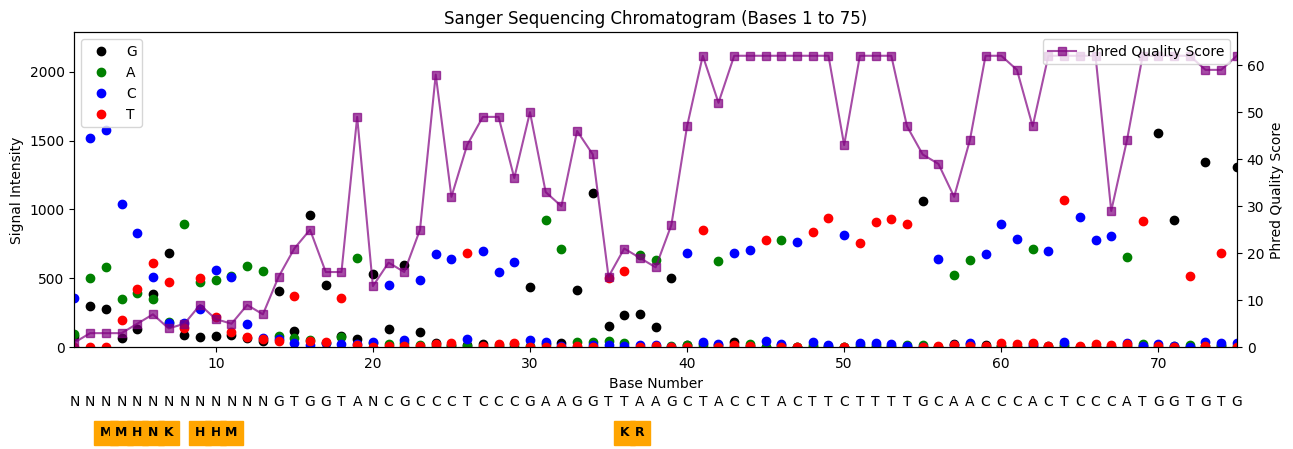

In [29]:
#if generate2.clicked:
record2 = None
if file2.filepath is not None:
    with open(file2.filepath, "rb") as infile:
        record2 = SeqIO.read(infile, "abi")

    seq2 = make_ambig_calls_and_plot(record2, orient = 'R')

In [127]:
from Bio import pairwise2

# Perform local alignment using Smith-Waterman
def align_sequences(seq1, seq2):
    # Perform local alignment using Smith-Waterman (localms)
    alignments = pairwise2.align.localms(seq1, seq2, 2, -1, -5, -2, one_alignment_only=True)
    
    # Return the best alignment
    return alignments[0]

# Function to generate consensus sequence based on Phred scores
def generate_consensus_with_phred(aligned_seq1, aligned_seq2, phred_scores1, phred_scores2):
    consensus = []
    source_base = [] # 1 is seq1, 2 is seq2, 3 is they called same base, 4 is they called different base but equal phred score

    # Iterate through the aligned sequences and compare each base
    for i, (base1, base2) in enumerate(zip(aligned_seq1, aligned_seq2)):
        # Handle gaps
        if base1 == '-':
            consensus.append(base2)
            source_base.append(2)
        elif base2 == '-':
            consensus.append(base1)
            source_base.append(1)
        elif base1 == base2:
            consensus.append(base1) # If bases are the same, use either one
            source_base.append(3)
        else:
            # Compare Phred scores to choose the base with the higher score
            if phred_scores1[i] > phred_scores2[i]:
                consensus.append(base1)
                source_base.append(1)
            elif phred_scores2[i] > phred_scores1[i]:
                consensus.append(base2)
                source_base.append(2)
            # this would be unlikely, but would handle situations where phred scores are equal
            elif phred_scores1[i] == phred_scores2[i]:
                # first will need to convert any IUPAC codes *back* to bases:
                possible_calls = set()
                if base1 not in ['A', 'C', 'G', 'T']:
                    base1_set = set(iupac_codes[base1])
                    possible_calls.update(base1_set)
                    
                else: possible_calls.add(base1)
                        
                if base2 not in ['A', 'C', 'G', 'T']:
                    base2_set = set(iupac_codes[base2])
                    possible_calls.update(base2_set)
                    
                else: possible_calls.add(base2)
                
                sorted_possible_calls = ''.join(sorted(list(possible_calls)))
                consensus.append(base_to_iupac.get(sorted_possible_calls, 'N'))  # Return 'N' if no match is found
                source_base.append(4)
                
    return ''.join(consensus), source_base

# Main function to align sequences and generate the consensus
def align_and_generate_consensus(seq1, seq2):
    # Align sequences
    best_alignment = align_sequences(seq1.seq, seq2.seq)
    
    phred_scores1 = seq1.letter_annotations["phred_score"]
    phred_scores2 = seq2.letter_annotations["phred_score"]
    
    # Extract the aligned sequences
    aligned_seq1, aligned_seq2, score, start, end = best_alignment
    
    # Generate consensus sequence based on Phred scores
    consensus_sequence, source_base = generate_consensus_with_phred(aligned_seq1, aligned_seq2, phred_scores1, phred_scores2)

    # Print the alignment and the consensus sequence
    print("Alignment:")
    print(pairwise2.format_alignment(*best_alignment))

    # Print the alignment and the consensus sequence
    print(f"Consensus sequence generated with length of {str(len(consensus_sequence))} bases.")
    
    return consensus_sequence, source_base

## Find overlap between forward and reverse reads and merge sequences

In [279]:
seq2.seq[570:]

Seq('AGGGCTACACACGTGCTACAATGGCATATACAAAGAGAAGCGACCTCGCGAGAG...TAG')

In [281]:
seqA, seqB, score, start, end = best_alignment

In [284]:
seqA[570:]

'GGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCTGTAAACGATGTCGACTTGGAGGTTGTGCCCTTGA---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

In [285]:
seqB[570:]

'GGCTAGAGTYTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCTGTAAACGATGTCGACTTGGAGGTTGTGCCCTTGAGGCGTGGCTTCCGGAGCTAACGCGTTAAGTCGACCGCCTGGGGAGTACGGCCGCAAGGTTAAAACTCAAATGAATTGACGGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTACTCTTGACATCCACGGAATTTGGCAGAGATGCCTWAGTGCCTTCGGGAACCGTGAGACAGGTGCTGCATGGCTGTCGTCAGCTCGTGTTGTGAAATGTTGGGTTAAGTCCCGCAACGAGCGCAACCCTTATCCTTTGTTGCCAGCGRTTCNNYNNGGAACTCAAAGGAGACTGCCAGTGATAAACTGGAGGAAGGTGGGGATGACGTCAAGTCATCATGGCCCTTACGAGTAGGGCTACACACGTGCTACAATGGCATATACAAAGAGAAGCGACCTCGCGAGAGCAAGCGGACCTCATAAAGTATGTCGTAGTCCGGATCGGAGTCTGCAACTCGACTCCGTGAAGTCGGAATCGCTAGTAATCGTGGATCAGAATGCCACGGTGAATACGTTCCCGGGCCTTGTACACACCGCCCGTCACACCATGGGAGTGGGTTGCAAAAGAAGTAGGTAG'

In [262]:
best_alignment

Alignment(seqA='GAGAGCTTGCTCTCGGGTGACGAGCGGCGGACGGGTGAGTAATGTCTGGGAAACTGCCTGATGGAGGGGGATAACTACTGGAAACGGTAGCTAATACCGCATAACGTCTTCGGACCAAAGTGGGGGACCTTCGGGCCTCATGCCATCAGATGTGCCCAGATGGGATTAGCTAGCAGGTGAGGTAATGGCTCACCTGGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCAGCCACACTGGAACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTATGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGCGGGGAGGAAGGCRATAAGGTTAATAACCTTGTYGATTGACGTTACCCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTCTGTCAAGTCGGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTCGAAACTGGCAGGCTAGAGTCTTGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCTGTAAACGATGTCGACTTGGAGGTTGTGCCCTTGA-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [263]:
seq2.seq[570:]

Seq('AGGGCTACACACGTGCTACAATGGCATATACAAAGAGAAGCGACCTCGCGAGAG...TAG')

In [226]:
color_dict = {1: 'blue', 2: 'red', 3: 'green', 4: 'orange'}

In [252]:
generate3 = mr.Button(label = "Find overlap consensus")

if generate3.clicked:
    consensus, source_base = align_and_generate_consensus(seq1, seq2)
    pos_to_split = np.where(np.array(source_base)[:-1] != np.array(source_base)[1:])[0] # find out where the source base changes
    pos_to_split = pos_to_split + 1 # adjust so list shows end position
    pos_to_split = pos_to_split.tolist() # convert to list
    pos_to_split.insert(0, 0) # add zero to beginning of list
    pos_to_split.append(len(consensus)) # add end of sequence
    to_print = str()
    print(pos_to_split)

    for i, pos in enumerate(pos_to_split):
        if i == 0:
            continue
        start = pos_to_split[i-1]
        end = pos_to_split[i]
        new_section = consensus[start:end]
    
        col = color_dict[source_base[start]]
        to_print += colorize(new_section, color = col)

    print(consensus)

    print('')

    print('Scroll the sequence below to see the alignment region and which read the base calls came from.')

    display(Markdown(colorize('Forward read', 'blue')))
    display(Markdown(colorize('Reverse read', 'red')))
    display(Markdown(colorize('Alignment (reads agree)', 'green')))

    # Highlight ambiguous/noncanonical bases
    ambig_base_codes = ['R', 'Y', 'S', 'W', 'K', 'M', 'B', 'D', 'H', 'V', 'N']

    pre = "<span style='background-color: yellow'>"
    post = "</span>"
    for ambig in ambig_base_codes:
        to_print = to_print.replace(ambig, pre + ambig + post)
        
    display(Markdown(to_print))

mercury.Button

In [229]:
merge_title = mr.Text(value='', label='Name the merged sequence for export', rows = 1)
merge_desc = mr.Text(value='', label='Give a description of the file', rows = 1)

generate4 = mr.Button(label = "Write to FASTA")

if generate4.clicked:
    with open(f"/home/dutcheah/Projects/mercury/merged_fastas/{merge_title.value}.fasta", 'w') as outfile:
        SeqIO.write(SeqRecord(Seq(consensus), id=merge_title.value, description=merge_desc.value), outfile, 'fasta')

    print("Fasta successfully generated")

mercury.Text

mercury.Text

mercury.Button